In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             roc_curve, roc_auc_score, precision_recall_curve, average_precision_score)
from scipy.stats import chi2_contingency, ttest_ind  # for chi-square, t-tests


In [35]:

# 1. LOAD DATA
file_path = "titanic_survival.csv"  # Ensure the correct file path
df = pd.read_csv(file_path)


In [36]:

# 2. DROP UNNECESSARY COLUMNS
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)


# 3. EXPLORATORY DATA ANALYSIS

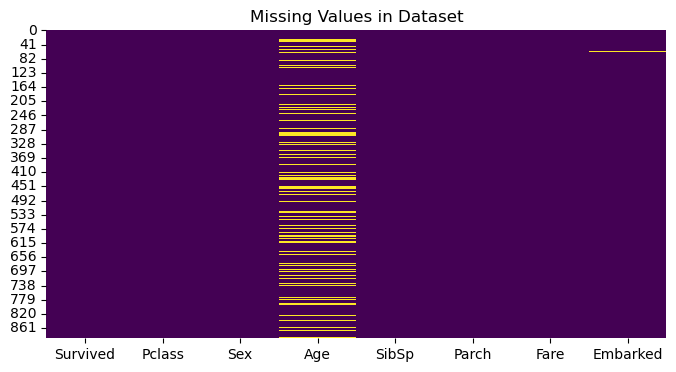

In [37]:

## 3A. MISSING VALUES
plt.figure(figsize=(8, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()


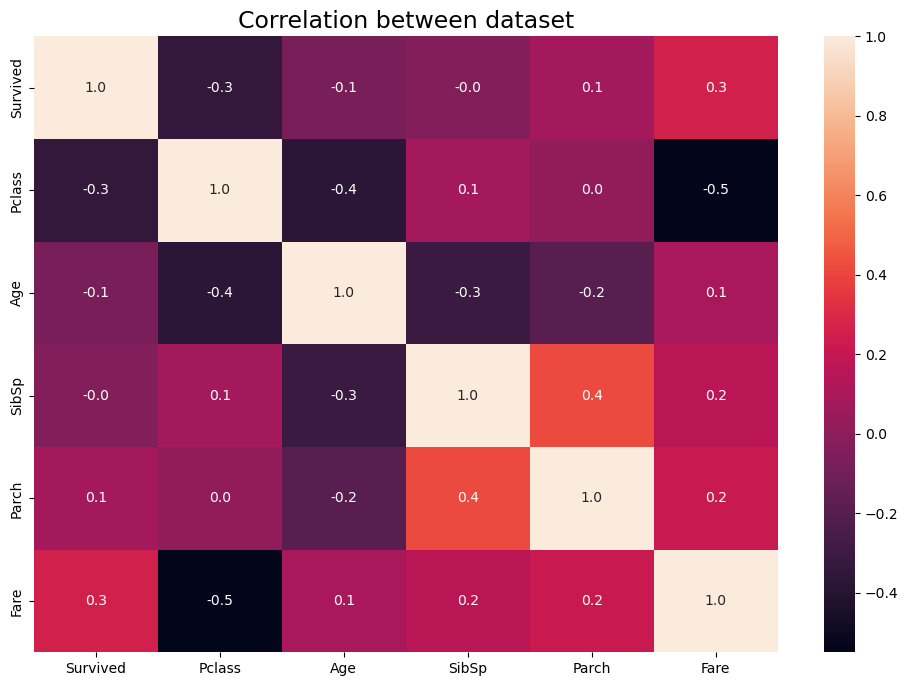

In [38]:
# Correlation heatmap
plt.figure(figsize=(12,8))
c=df.corr(numeric_only=True)
sns.heatmap(c,annot=True,fmt=".1f")
plt.title("Correlation between dataset",fontsize=17,c="k")
plt.show()

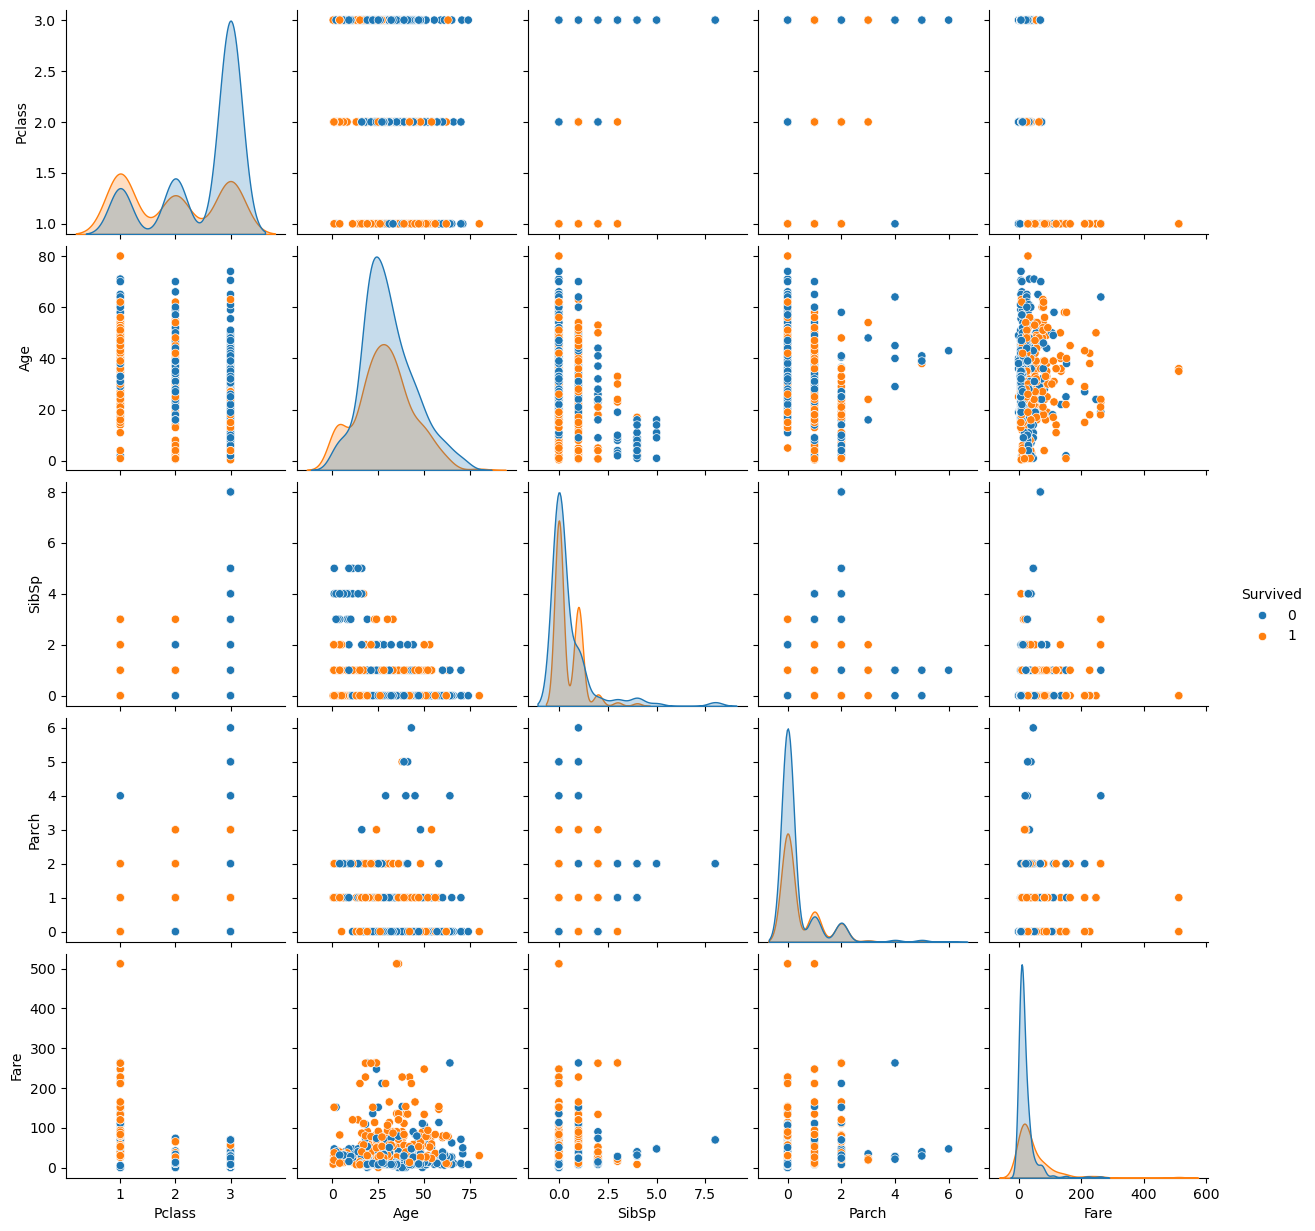

In [39]:

## 3B. PAIRPLOT (GENERAL RELATIONSHIPS)
sns.pairplot(df, hue="Survived", diag_kind='kde')
plt.show()


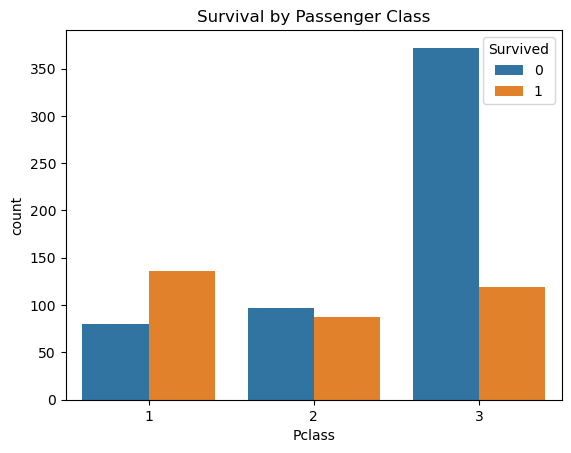

In [40]:

## 3C. SURVIVAL BY PASSENGER CLASS
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title("Survival by Passenger Class")
plt.show()


# 4. AGE GROUPS FOR VISUALIZATION

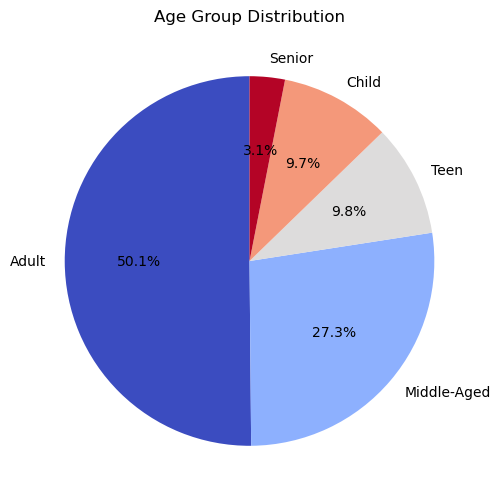

In [41]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                        labels=['Child', 'Teen', 'Adult', 'Middle-Aged', 'Senior'])

## 4A. PIE CHART OF AGE GROUP
plt.figure(figsize=(6, 6))
df['AgeGroup'].value_counts().plot.pie(autopct="%1.1f%%", cmap='coolwarm', startangle=90)
plt.title("Age Group Distribution")
plt.ylabel('')
plt.show()


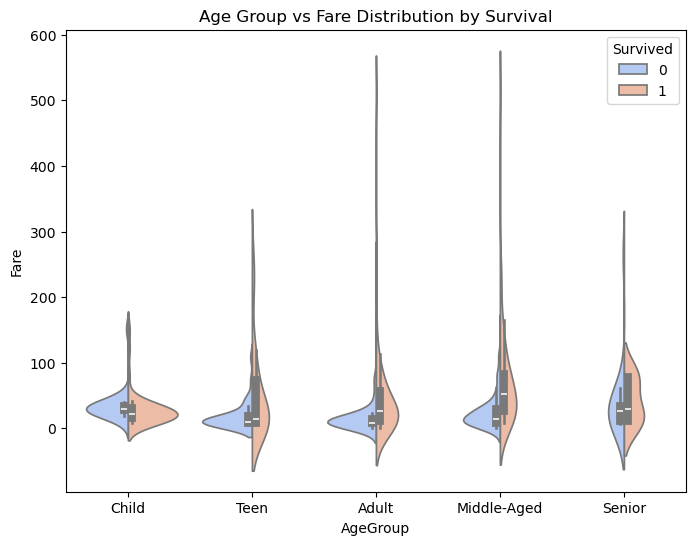

In [42]:

## 4B. VIOLIN PLOT FOR FARE BY AGE GROUP & SURVIVAL
plt.figure(figsize=(8, 6))
sns.violinplot(x='AgeGroup', y='Fare', hue='Survived', data=df, split=True, palette='coolwarm')
plt.title("Age Group vs Fare Distribution by Survival")
plt.show()


# 5. STATISTICAL TESTS


In [43]:

## 5A. CHI-SQUARE TESTS FOR CATEGORICAL FEATURES
categorical_features = ['Sex', 'Embarked', 'Pclass']
for cat in categorical_features:
    contingency_table = pd.crosstab(df[cat], df['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-square test for {cat} vs Survived:")
    print("Chi2 statistic =", chi2)
    print("p-value =", p)



Chi-square test for Sex vs Survived:
Chi2 statistic = 260.71702016732104
p-value = 1.1973570627755645e-58

Chi-square test for Embarked vs Survived:
Chi2 statistic = 26.48914983923762
p-value = 1.769922284120912e-06

Chi-square test for Pclass vs Survived:
Chi2 statistic = 102.88898875696056
p-value = 4.549251711298793e-23


In [44]:

## 5B. T-TEST FOR NUMERIC FEATURES (e.g., Age, Fare) BY SURVIVAL
numeric_features = ['Age', 'Fare']
for num in numeric_features:
    survived_vals = df[df['Survived'] == 1][num].dropna()
    not_survived_vals = df[df['Survived'] == 0][num].dropna()
    t_stat, p_val = ttest_ind(survived_vals, not_survived_vals, equal_var=False)
    print(f"\nT-test for {num} by Survival:")
    print("T-statistic =", t_stat)
    print("p-value =", p_val)



T-test for Age by Survival:
T-statistic = -2.0460301043939704
p-value = 0.04118965162586639

T-test for Fare by Survival:
T-statistic = 6.839099259085254
p-value = 2.6993323503141236e-11


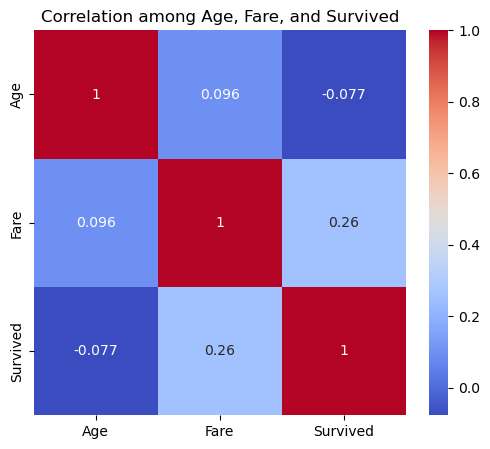

In [45]:

## 5C. CORRELATION ANALYSIS (numeric columns)
corr_columns = ['Age','Fare','Survived']
corr_matrix = df[corr_columns].corr(method='pearson')
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation among Age, Fare, and Survived")
plt.show()


In [46]:

# 6. DATA PREPROCESSING
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

num_features = ['Age', 'Fare']
cat_features = ['Sex', 'Embarked', 'Pclass']

preprocessor = ColumnTransformer([
    ('num', Pipeline([('imputer', num_imputer), ('scaler', scaler)]), num_features),
    ('cat', Pipeline([('imputer', cat_imputer), ('encoder', encoder)]), cat_features)
])


In [47]:

# 7. TRAIN-TEST SPLIT
X = df.drop(['Survived', 'AgeGroup'], axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:

# 8. LOGISTIC REGRESSION
log_reg_pipline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=2000))
])
log_reg_pipline_pipeline.fit(X_train, y_train)

# y_pred_log = log_reg_pipline_pipeline.predict(X_test)

# print("\n=== Logistic Regression ===")
# print("Accuracy:", accuracy_score(y_test, y_pred_log))
# print(classification_report(y_test, y_pred_log))


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked',
                                                   'Pclass'])])),
                ('classifier', LogisticRegression(max_iter=2000))])

In [49]:
# Predict on the training and testing set using logistic regression model
y_pred_train_log_reg_pipline = log_reg_pipline_pipeline.predict(X_train)
y_pred_test_log_reg_pipline = log_reg_pipline_pipeline.predict(X_test)

print("\n=== Logistic Regression ===")
print("Training set Accuracy:", accuracy_score(y_train, y_pred_train_log_reg_pipline))
print("Clssification Report for training data")
print(classification_report(y_train, y_pred_train_log_reg_pipline))

print("Testing set Accuracy:", accuracy_score(y_test, y_pred_test_log_reg_pipline))
print("Clssification Report for testing data")
print(classification_report(y_test, y_pred_test_log_reg_pipline))


=== Logistic Regression ===
Training set Accuracy: 0.7963483146067416
Clssification Report for training data
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       444
           1       0.74      0.71      0.72       268

    accuracy                           0.80       712
   macro avg       0.78      0.78      0.78       712
weighted avg       0.79      0.80      0.80       712

Testing set Accuracy: 0.7932960893854749
Clssification Report for testing data
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       105
           1       0.76      0.73      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.79      0.79      0.79       179



In [50]:

# 9. DECISION TREE WITH GRID SEARCH
param_grid = {
    'classifier__max_depth': [3, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
grid_search = GridSearchCV(dt_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

dt_best_model = grid_search.best_estimator_
y_pred_dt = dt_best_model.predict(X_test)

print("\n=== Decision Tree ===")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))



=== Decision Tree ===
Best Parameters: {'classifier__max_depth': 3, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [51]:

# 10. RANDOM FOREST CLASSIFIER
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))



=== Random Forest ===
Accuracy: 0.7932960893854749
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       105
           1       0.75      0.74      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



In [53]:

# 11. CROSS-VALIDATION (LOGISTIC REGRESSION EXAMPLE)
cv_scores = cross_val_score(log_reg_pipeline, X, y, cv=5, scoring='accuracy')
print("\nLogistic Regression CV Accuracy (mean):", np.mean(cv_scores))
print("All CV scores:", cv_scores)



Logistic Regression CV Accuracy (mean): 0.7901324461741258
All CV scores: [0.78212291 0.81460674 0.78089888 0.76966292 0.80337079]


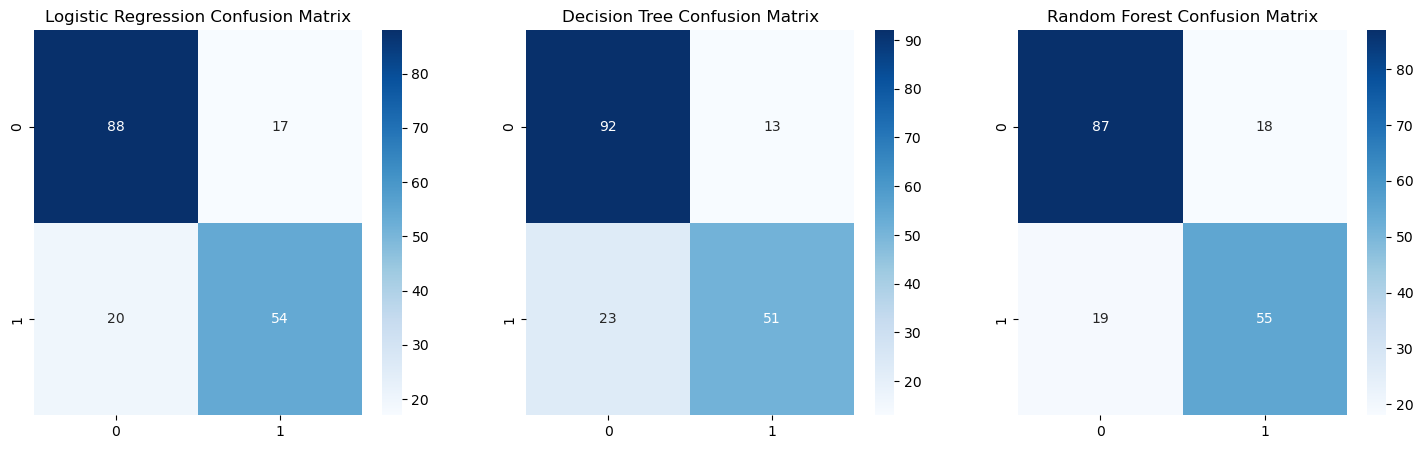

In [54]:

# 12. CONFUSION MATRICES
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')

plt.show()


The Area under the region of Convergence for Logistic Regression:  0.8759
Optimal Threshold: 0.3342


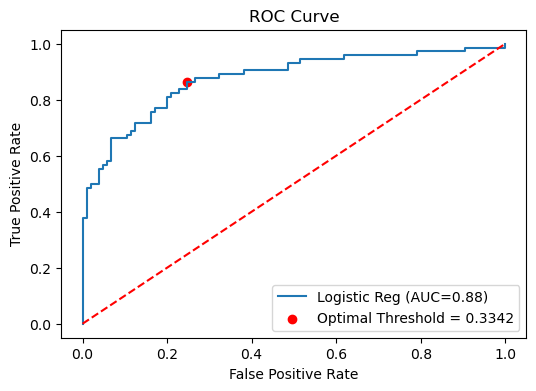

In [62]:

# 13. ROC CURVES & AUC
# Demostrated with Logistic Regression; repeat similarly for DT/RF if desired.
y_pred_probs_log = log_reg_pipeline.predict_proba(X_test)[:, 1]  # Probability of survival (class=1)
fpr_log, tpr_log, thresholds = roc_curve(y_test, y_pred_probs_log)
roc_auc_log = roc_auc_score(y_test, y_pred_probs_log)

# Compute Youden's J statistic for each threshold
youden_j = tpr_log - fpr_log
optimal_threshold_index = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_threshold_index]
print(f"The Area under the region of Convergence for Logistic Regression: {roc_auc_log: .4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(fpr_log, tpr_log, label=f'Logistic Reg (AUC={roc_auc_log:.2f})')
plt.scatter(fpr_log[optimal_threshold_index], tpr_log[optimal_threshold_index], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


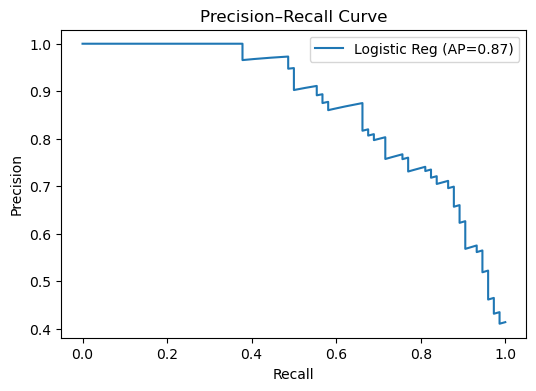

In [57]:

# 14. PRECISION–RECALL CURVE
prec_log, recall_log, _ = precision_recall_curve(y_test, y_pred_probs_log)
avg_precision_log = average_precision_score(y_test, y_pred_probs_log)

plt.figure(figsize=(6, 4))
plt.plot(recall_log, prec_log, label=f'Logistic Reg (AP={avg_precision_log:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()


In [58]:

# Generating EDA Report
report = """
### Titanic Data Analysis Report

1. Majority did not survive. 

2. Age Group Analysis:
   - Children had a higher survival rate. Older adults had lower survival chances.
   - Age distribution varies, as shown in violin plots.Younger passengers, particularly children, 
     had a higher survival rate—likely due to "women and children first" evacuation protocols.

3. Family Factor:
   - Passengers traveling alone had a lower survival rate compared to those with family.

4. Fare and Survival:
   - Higher fare-paying passengers had better chances of survival.
     Survival chances increased with ticket class (higher class had higher survival rate).

5. Embarkment Influence:
   - Passengers embarking from certain ports had different survival probabilities.

### Notable Inferences:
- Being in a higher class, traveling with family, and paying a higher fare positively influenced survival.
- Age played a role in survival, with younger individuals having a higher chance.
- Further analysis can be done with machine learning models for deeper insights.
"""

print(report)


### Titanic Data Analysis Report

1. Majority did not survive. 

2. Age Group Analysis:
   - Children had a higher survival rate. Older adults had lower survival chances.
   - Age distribution varies, as shown in violin plots.Younger passengers, particularly children, 
     had a higher survival rate—likely due to "women and children first" evacuation protocols.

3. Family Factor:
   - Passengers traveling alone had a lower survival rate compared to those with family.

4. Fare and Survival:
   - Higher fare-paying passengers had better chances of survival.
     Survival chances increased with ticket class (higher class had higher survival rate).

5. Embarkment Influence:
   - Passengers embarking from certain ports had different survival probabilities.

### Notable Inferences:
- Being in a higher class, traveling with family, and paying a higher fare positively influenced survival.
- Age played a role in survival, with younger individuals having a higher chance.
- Further analysis can